<a href="https://colab.research.google.com/github/mangoubi/DS595-ST-Machine-Learning-for-Engineering-Science-Applications/blob/main/MNIST_Classifier_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code constructs and trains a neural network which allows the computer to read hand-writting.

We are given a dataset of hand-written digits (the so-called "MNIST" datset), and the goal is to train a neural network to classify which hand-written digit is in an image.

In [1]:
import torch
import torchvision

Setting the hyperparameters of the optimization algorithm.  We will use the optimization algorithm to train the neural network.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
#learning_rate = 0.01
#momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Loading the MNIST dataset

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

Printing some of the images in the dataset

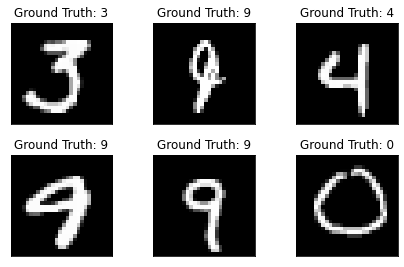

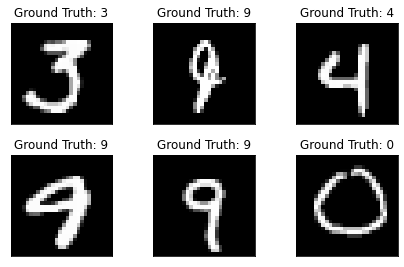

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Building the neural network.  The neural network is made up of many layers.  

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Choosing which optimization algorithm to use.  The choices are
1) stochastic gradient descent (SGD) with momentum 

2) ADAM.

You also need to set the values of the hyperparameters of the optimization algorithm:  lr (stands for "learning rate"),  and momentum (only for SGD).

In [19]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
#optimizer = optim.Adam(network.parameters(), lr=0.0001)

In [20]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

Here we define the "training" function which we will use to train the neural network.

In [21]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

Here we define the "test" function which we will use to test the neural network.

In [22]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Training the model.  Here we actually run the optimization algorithm to train the neural network.  This will take some time, since the optimization algorithm takes many, many steps.

In [23]:
train_counter =[]
test_counter
train_losses=[]
test_losses=[]
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3150, Accuracy: 1123/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340430
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.327765
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.256921
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299219
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.230854
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.211785
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.169122
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.099493
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.147993
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.937628
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.867552
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.763148
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.609868
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.380298
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.371080
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.509219
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.192978
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.154502
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.407695
Train Epoch: 1 [12160

Evaluating the model's performance

Text(0, 0.5, 'negative log likelihood loss')

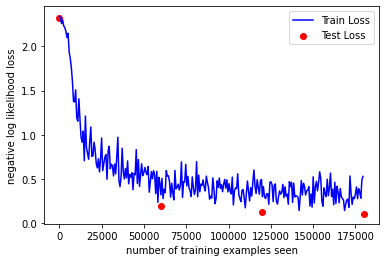

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

What?  It looks like the test loss is lower than the training loss.  How is this possible?  Here are some reasons, but the basic idea is that they are comparing slightly different versions of the neural network:  https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e

In [25]:
with torch.no_grad():
  output = network(example_data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


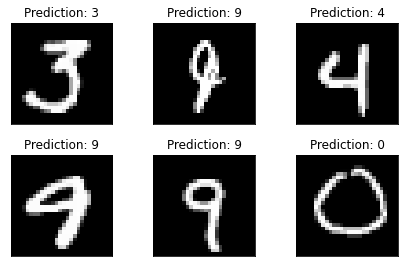

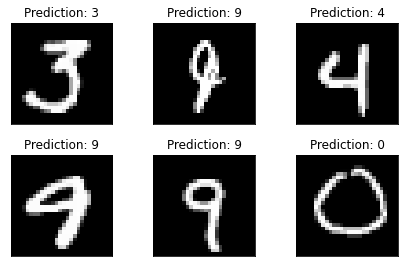

In [27]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Note: the above code is from the demo https://nextjournal.com/gkoehler/pytorch-mnist